In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
from torch.utils.data import DataLoader
from typing import Tuple, Optional
import logging
import os
from torch.utils.data import Dataset
import cv2

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

def generate_existing_folders(directory, start, end):
        existing_folders = []
        for i in range(start, end + 1):
            folder_name = f"{i:03}"  # Format number with leading zeros
            folder_path = os.path.join(directory, folder_name)
            if os.path.isdir(folder_path):  # Check if the folder exists
                existing_folders.append(folder_name)
        return existing_folders

In [22]:
class VW300Dataset(Dataset):
    def __init__(self, data_root, mode, clip_len=16, frame_sample_rate=2, crop_size=224, use_augmentation=False):
        """
        Initialize the 300-VW dataset loader.
        
        Args:
            data_root (str): Root directory containing the dataset folders
            mode (str): Dataset split ('train', 'validation', 'test')
            clip_len (int): Number of frames per video clip
            frame_sample_rate (int): Frame sampling rate
            crop_size (int): Size to crop/resize frames to
            use_augmentation (bool): Whether to use data augmentation in training mode
        """
        self.data_root = data_root
        self.mode = mode
        self.clip_len = clip_len
        self.frame_sample_rate = frame_sample_rate
        self.crop_size = crop_size
        self.use_augmentation = use_augmentation
        
        # Load clip directories based on the split
        self.clips = self._get_split_clips()
        self.annotations = self._load_annotations()
        
    def _get_split_clips(self):
        """
        Get list of clip directories based on the dataset split.
        Implement according to 300-VW official split.
        """
        # These splits should be adjusted according to official 300-VW protocol
        splits = {
            'train': generate_existing_folders(self.data_root, 1, 480),  # Add actual training clip numbers
            'validation': generate_existing_folders(self.data_root, 481, 530),     # Add actual validation clip numbers
            'test': generate_existing_folders(self.data_root, 531, 570)           # Add actual test clip numbers
        }
        print(splits)
        return [os.path.join(self.data_root, clip_id) for clip_id in splits[self.mode]]
    
    def _load_annotations(self):
        """
        Load all clip annotations.
        Returns list of (video_path, landmarks_dir) tuples.
        """
        annotations = []
        for clip_dir in self.clips:
            video_path = os.path.join(clip_dir, 'vid.avi')
            landmarks_dir = os.path.join(clip_dir, 'annot')
            
            if not os.path.exists(video_path):
                raise FileNotFoundError(f"Video file not found: {video_path}")
            if not os.path.exists(landmarks_dir):
                raise FileNotFoundError(f"Landmarks directory not found: {landmarks_dir}")
                
            # Get number of frames in video
            cap = cv2.VideoCapture(video_path)
            n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            cap.release()
            
            # Verify landmark files exist and have correct number of points
            n_landmarks = None
            for i in range(1, n_frames + 1):  # 300-VW uses 1-based indexing
                pts_path = os.path.join(landmarks_dir, f'{str(i).zfill(6)}.pts')
                if not os.path.exists(pts_path):
                    raise FileNotFoundError(f"Missing landmark file for frame {i} in {clip_dir}")
                
                # Validate landmark count consistency
                landmarks = self._load_pts_file(pts_path)
                if n_landmarks is None:
                    n_landmarks = len(landmarks)
                elif len(landmarks) != n_landmarks:
                    raise ValueError(f"Inconsistent landmark count in {pts_path}. Expected {n_landmarks}, got {len(landmarks)}")
                    
            self.n_landmarks = n_landmarks  # Store for reference
            
            annotations.append((video_path, landmarks_dir, n_frames))
        
        return annotations
    
    def _load_pts_file(self, pts_path):
        landmarks = []
        with open(pts_path, 'r') as f:
            lines = f.readlines()
            start_idx = 0
            end_idx = len(lines)
            
            # Find the starting and ending brackets
            for i, line in enumerate(lines):
                if '{' in line:
                    start_idx = i + 1
                elif '}' in line:
                    end_idx = i
                    break
            
            # Parse coordinates
            for line in lines[start_idx:end_idx]:
                if line.strip():  # Skip empty lines
                    try:
                        x, y = map(float, line.strip().split())
                        landmarks.append([x, y])
                    except ValueError as e:
                        print(f"Error parsing line in {pts_path}: {line}")
                        raise e
                        
        return np.array(landmarks)
    
    def _load_video_segment(self, video_path, start_frame, n_frames):
        """
        Load a segment of video frames efficiently.
        """
        frames = []
        cap = cv2.VideoCapture(video_path)
        
        # Get video properties
        orig_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        orig_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        
        # Calculate resize dimensions once
        scale = self.crop_size / min(orig_h, orig_w)
        new_h, new_w = int(orig_h * scale), int(orig_w * scale)
        start_h = (new_h - self.crop_size) // 2
        start_w = (new_w - self.crop_size) // 2
        
        # Set starting frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        
        # Preallocate numpy array for batch processing
        frames = np.empty((n_frames, self.crop_size, self.crop_size, 3), dtype=np.uint8)
        
        for i in range(n_frames):
            ret, frame = cap.read()
            if not ret:
                raise ValueError(f"Failed to read frame {start_frame + i} from {video_path}")
            
            # Resize and crop
            frame = cv2.resize(frame, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
            frame = frame[start_h:start_h + self.crop_size, 
                         start_w:start_w + self.crop_size]
            frames[i] = frame
        
        cap.release()
        
        # Convert to tensor
        return torch.from_numpy(frames).permute(0, 3, 1, 2).float() / 255.0  # (T, C, H, W)
    
    def _load_landmarks_segment(self, landmarks_dir, start_frame, n_frames):
        """
        Load landmarks for a segment of frames.
        """
        landmarks = []
        for frame_idx in range(start_frame + 1, start_frame + n_frames + 1):
            pts_path = os.path.join(landmarks_dir, f'{str(frame_idx).zfill(6)}.pts')
            frame_landmarks = self._load_pts_file(pts_path)
            
            # Normalize landmarks to [0, 1] range
            # Apply same transform as frames
            h, w = frame_landmarks.max(axis=0) - frame_landmarks.min(axis=0)
            scale = self.crop_size / min(h, w)
            frame_landmarks = frame_landmarks * scale
            
            # Center crop adjustment
            center = frame_landmarks.mean(axis=0)
            crop_start = center - (self.crop_size / 2)
            frame_landmarks = frame_landmarks - crop_start
            
            # Normalize to [0, 1]
            frame_landmarks = frame_landmarks / self.crop_size
            
            # Clip to valid range
            frame_landmarks = np.clip(frame_landmarks, 0, 1)
            landmarks.append(frame_landmarks)
            
        return torch.tensor(landmarks).float()  # (T, N, 2)
    
    def __getitem__(self, index):
        """
        Get a video clip and corresponding landmarks.
        """
        video_path, landmarks_dir, total_frames = self.annotations[index]
        
        # Randomly sample a starting frame
        max_start = total_frames - self.clip_len * self.frame_sample_rate
        if max_start <= 0:
            raise ValueError(f"Video {video_path} is too short for the specified clip length and sampling rate")
        
        if self.mode == 'train':
            start_frame = np.random.randint(0, max_start)
        else:
            # For validation/test, take center clip
            start_frame = max_start // 2
            
        # Load video frames and landmarks
        frames = self._load_video_segment(
            video_path, 
            start_frame, 
            self.clip_len * self.frame_sample_rate
        )[::self.frame_sample_rate]  # Apply frame sampling
        
        landmarks = self._load_landmarks_segment(
            landmarks_dir,
            start_frame,
            self.clip_len * self.frame_sample_rate
        )[::self.frame_sample_rate]  # Apply frame sampling
        
        # Apply augmentations in training mode
        if self.mode == 'train' and self.use_augmentation:
            # Random horizontal flip
            if torch.rand(1) > 0.5:
                frames = torch.flip(frames, [-1])
                landmarks[..., 0] = 1 - landmarks[..., 0]  # Flip x coordinates
                
                # TODO: Could add color augmentation here
                # TODO: Could add random cropping here
                
        return frames, landmarks
    
    def __len__(self):
        return len(self.annotations)

In [23]:
def build_dataset(is_train, test_mode, args):
    """
    Build 300-VW dataset.
    """
    mode = 'train' if is_train else 'test' if test_mode else 'validation'
    
    dataset = VW300Dataset(
        data_root=args.data_path,
        mode=mode,
        clip_len=args.num_frames,
        frame_sample_rate=args.sampling_rate,
        crop_size=args.input_size
    )
    
    print(f"300-VW dataset built successfully for mode: {mode}")
    print(f"Number of clips: {len(dataset)}")
    
    return dataset

{'train': ['001', '002', '003', '004', '007', '009', '010', '011', '013', '015', '016', '017', '018', '019', '020', '022', '025', '027', '028', '029', '031', '033', '034', '035', '037', '039', '041', '043', '044', '046', '047', '048', '049', '053', '057', '059', '112', '113', '114', '115', '119', '120', '123', '124', '125', '126', '138', '143', '144', '150', '158', '160', '203', '204', '205', '208', '211', '212', '213', '214', '218', '223', '224', '225', '401', '402', '403', '404', '405', '406', '407', '408', '409', '410', '411', '412'], 'validation': ['505', '506', '507', '508', '509', '510', '511', '514', '515', '516', '517', '518', '519', '520', '521', '522', '524', '525', '526', '528', '529', '530'], 'test': ['531', '533', '537', '538', '540', '541', '546', '547', '548', '550', '551', '553', '557', '558', '559', '562']}
300-VW dataset built successfully for mode: train
Number of clips: 76
Sample 1:
  Frames shape: torch.Size([16, 3, 224, 224])
  Landmarks shape: torch.Size([16, 68,

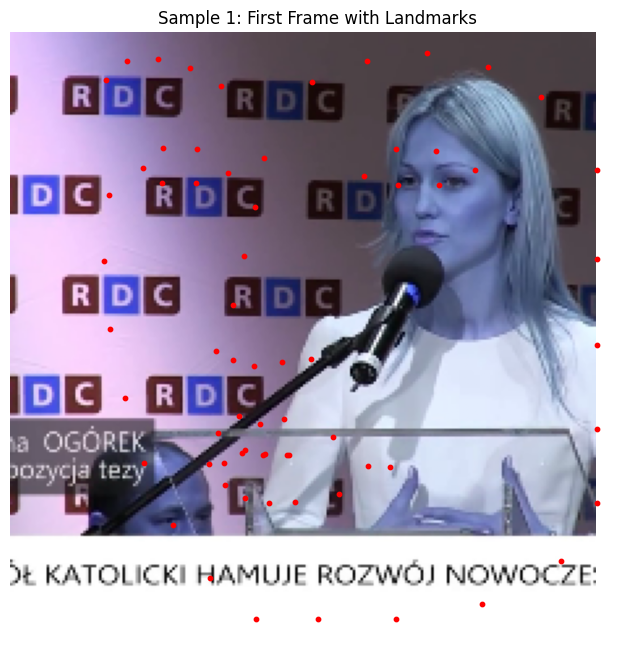

Sample 2:
  Frames shape: torch.Size([16, 3, 224, 224])
  Landmarks shape: torch.Size([16, 68, 2])


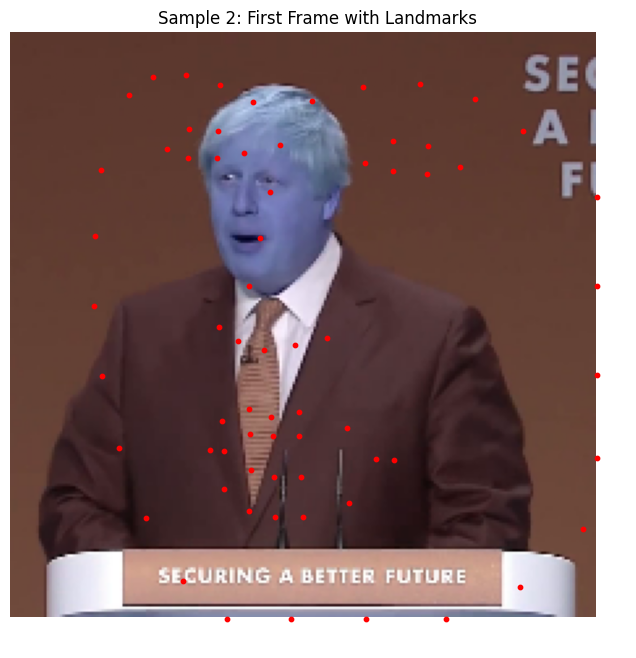

Sample 3:
  Frames shape: torch.Size([16, 3, 224, 224])
  Landmarks shape: torch.Size([16, 68, 2])


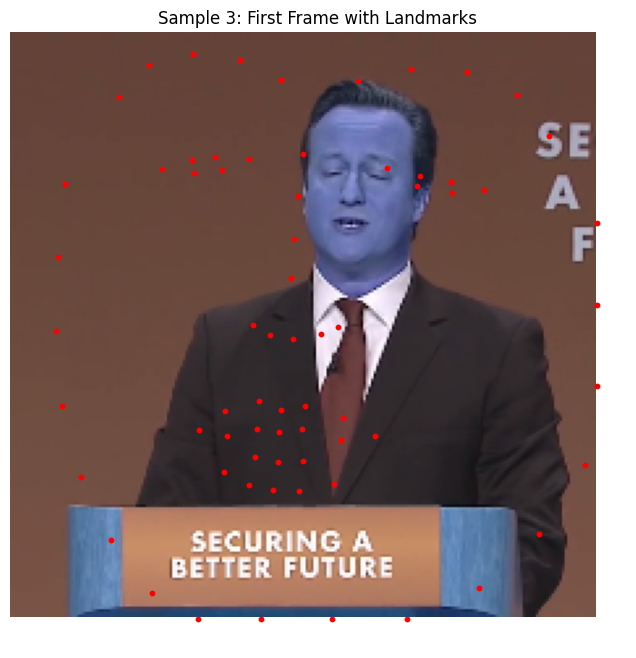

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def visualize_dataset(dataset, num_samples=3):
    """
    Visualize a few samples from the dataset.
    
    Args:
        dataset: An instance of VW300Dataset.
        num_samples: Number of samples to visualize.
    """
    for idx in range(min(num_samples, len(dataset))):
        frames, landmarks = dataset[idx]
        
        print(f"Sample {idx + 1}:")
        print(f"  Frames shape: {frames.shape}")  # (T, C, H, W)
        print(f"  Landmarks shape: {landmarks.shape}")  # (T, N, 2)
        
        # Visualize the first frame and its landmarks
        frame = frames[0].permute(1, 2, 0).numpy()  # Convert to HWC format for visualization
        landmark_points = landmarks[0].numpy()
        
        plt.figure(figsize=(8, 8))
        plt.imshow(frame)
        plt.scatter(
            landmark_points[:, 0] * frame.shape[1],  # Scale x coordinates to image size
            landmark_points[:, 1] * frame.shape[0],  # Scale y coordinates to image size
            color='red', s=10
        )
        plt.title(f"Sample {idx + 1}: First Frame with Landmarks")
        plt.axis('off')
        plt.show()

# Example usage
if __name__ == "__main__":
    # Build the dataset (adjust args accordingly)
    class Args:
        data_path = "300vw_dataset"
        num_frames = 16
        sampling_rate = 4
        input_size = 224
    
    args = Args()
    dataset = build_dataset(is_train=True, test_mode=False, args=args)
    
    # Visualize samples
    visualize_dataset(dataset)


In [ ]:
class Parameters:
    def __init__(self):
        # Dataset parameters
        self.data_set = 'UCF101'
        self.data_path = 'your_data_path'
        self.prefix = ''
        self.split = ' '
        self.filename_tmpl = 'img_{:05}.jpg'
        self.nb_classes = 101
        self.use_decord = True
        self.trimmed = 60
        self.time_stride = 16
        
        # Model parameters
        self.input_size = 224
        self.short_side_size = 224
        self.num_frames = 16
        self.sampling_rate = 4
        
        # Training parameters
        self.batch_size = 32
        self.num_workers = 4
        self.learning_rate = 0.001
        self.log_interval = 10
        self.epochs = 100
        self.test_num_segment = 5
        self.test_num_crop = 3

In [ ]:
class FacialLandmarkCNN(nn.Module):
    def __init__(self, args: Parameters, num_landmarks: int = 68):
        super(FacialLandmarkCNN, self).__init__()
        self.args = args
        
        # Load and modify ResNet backbone
        self.backbone = models.resnet18(pretrained=True)
        # Remove final FC and pooling layers
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])
        
        # Calculate output size from backbone
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, args.input_size, args.input_size)
            backbone_output = self.backbone(dummy_input)
            self.backbone_output_shape = backbone_output.shape[1:]
        
        # Temporal modeling with 3D convolutions
        self.temporal_conv = nn.Sequential(
            nn.Conv3d(self.backbone_output_shape[0], 128, kernel_size=(3, 3, 3), 
                     padding=(1, 1, 1)),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True)
        )
        
        # Adaptive pooling to ensure consistent size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((56, 56))
        
        # Refinement network with proper size handling
        self.refinement = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)
        )
        
        # Landmark prediction head
        self.landmark_head = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_landmarks * 2, kernel_size=1)
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize model weights using Kaiming initialization"""
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Conv3d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm3d)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        batch_size, num_frames, c, h, w = x.shape
        
        # Validate input dimensions
        if num_frames != self.args.num_frames:
            raise ValueError(f"Expected {self.args.num_frames} frames, got {num_frames}")
        if h != self.args.input_size or w != self.args.input_size:
            raise ValueError(f"Expected size {self.args.input_size}, got {h}x{w}")
        
        # Process all frames in parallel
        x = x.view(batch_size * num_frames, c, h, w)
        features = self.backbone(x)
        
        # Apply adaptive pooling to ensure consistent size
        features = self.adaptive_pool(features)
        
        # Extract landmarks and feature maps
        landmarks = self.landmark_head(features)
        landmarks = landmarks.view(batch_size, num_frames, -1, 2)
        
        # Generate feature maps
        feature_maps = torch.sigmoid(self.refinement(features))
        feature_maps = feature_maps.view(batch_size, num_frames, 1, h, w)
        
        return feature_maps, landmarks

class FacialLandmarkDetector:
    def __init__(self, args: Parameters):
        self.args = args
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = FacialLandmarkCNN(args).to(self.device)
        
        # Initialize loss functions with reduction method
        self.criterion_landmarks = nn.MSELoss(reduction='mean')
        self.criterion_features = nn.BCEWithLogitsLoss(reduction='mean')
        
        # Initialize optimizer with weight decay
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.args.learning_rate,
            weight_decay=0.01
        )
        
        # Initialize learning rate scheduler
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=5,
            verbose=True
        )
        
        # Initialize loss history
        self.train_losses = []
        self.val_losses = []
    
    @torch.no_grad()
    def create_landmark_map(self, landmarks: torch.Tensor, height: int, 
                          width: int, sigma: float = 3.0) -> torch.Tensor:
        """
        Create Gaussian heatmaps for landmarks with numerical stability improvements.
        
        Args:
            landmarks: Tensor of shape (batch_size, num_landmarks, 2)
            height: Height of output heatmap
            width: Width of output heatmap
            sigma: Standard deviation for Gaussian kernel
            
        Returns:
            Tensor of shape (batch_size, 1, height, width)
        """
        batch_size = landmarks.size(0)
        landmark_map = torch.zeros(batch_size, 1, height, width, 
                                 device=self.device)
        
        # Create coordinate grids
        y_grid, x_grid = torch.meshgrid(
            torch.arange(height, device=self.device),
            torch.arange(width, device=self.device)
        )
        
        # Pre-compute maximum square distance for clipping
        max_squared_dist = 9 * sigma * sigma
        
        for b in range(batch_size):
            for landmark in landmarks[b]:
                x, y = landmark
                
                # Skip if landmark is outside image bounds
                if not (0 <= x < width and 0 <= y < height):
                    continue
                
                # Compute distances efficiently using broadcasting
                squared_dist = (x_grid - x) ** 2 + (y_grid - y) ** 2
                
                # Clip distances for numerical stability
                squared_dist = torch.clamp(squared_dist, max=max_squared_dist)
                
                # Compute Gaussian values
                gaussian = torch.exp(-squared_dist / (2 * sigma * sigma))
                
                # Update landmark map using maximum values
                landmark_map[b, 0] = torch.maximum(landmark_map[b, 0], gaussian)
        
        return landmark_map
    
    def train_epoch(self, train_loader: DataLoader) -> float:
        """Train for one epoch and return average loss."""
        self.model.train()
        total_loss = 0.0
        num_batches = len(train_loader)
        
        for batch_idx, (data, target_landmarks) in enumerate(train_loader):
            # Skip invalid batches
            if data.size(1) != self.args.num_frames:
                continue
            
            # Move data to device
            data = data.to(self.device)
            target_landmarks = target_landmarks.to(self.device)
            
            self.optimizer.zero_grad()
            
            # Forward pass
            feature_maps, predicted_landmarks = self.model(data)
            
            # Create target maps efficiently
            target_maps = self.create_landmark_map(
                target_landmarks.view(-1, target_landmarks.size(-2), 2),
                data.size(-2), data.size(-1)
            ).view_as(feature_maps)
            
            # Compute losses
            landmark_loss = self.criterion_landmarks(
                predicted_landmarks, target_landmarks
            )
            feature_loss = self.criterion_features(feature_maps, target_maps)
            loss = landmark_loss + feature_loss
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            total_loss += loss.item()
            
            # Log progress
            if batch_idx % self.args.log_interval == 0:
                logger.info(
                    f'Train Batch: {batch_idx}/{num_batches} '
                    f'Loss: {loss.item():.6f}'
                )
        
        return total_loss / num_batches
    
    @torch.no_grad()
    def validate(self, val_loader: DataLoader) -> float:
        """Validate the model and return average validation loss."""
        self.model.eval()
        total_loss = 0.0
        num_batches = len(val_loader)
        
        for data, target_landmarks in val_loader:
            if data.size(1) != self.args.num_frames:
                continue
            
            data = data.to(self.device)
            target_landmarks = target_landmarks.to(self.device)
            
            # Forward pass
            feature_maps, predicted_landmarks = self.model(data)
            
            # Create target maps
            target_maps = self.create_landmark_map(
                target_landmarks.view(-1, target_landmarks.size(-2), 2),
                data.size(-2), data.size(-1)
            ).view_as(feature_maps)
            
            # Compute losses
            landmark_loss = self.criterion_landmarks(
                predicted_landmarks, target_landmarks
            )
            feature_loss = self.criterion_features(feature_maps, target_maps)
            loss = landmark_loss + feature_loss
            
            total_loss += loss.item()
        
        return total_loss / num_batches
    
    def train(self, train_loader: DataLoader, val_loader: DataLoader, 
              num_epochs: Optional[int] = None) -> None:
        """Train the model for specified number of epochs."""
        num_epochs = num_epochs or self.args.epochs
        best_val_loss = float('inf')
        patience = 10
        patience_counter = 0
        
        for epoch in range(num_epochs):
            logger.info(f'\nEpoch: {epoch+1}/{num_epochs}')
            
            # Train and validate
            train_loss = self.train_epoch(train_loader)
            val_loss = self.validate(val_loader)
            
            # Update learning rate
            self.scheduler.step(val_loss)
            
            # Store losses
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            
            logger.info(f'Training Loss: {train_loss:.6f}')
            logger.info(f'Validation Loss: {val_loss:.6f}')
            
            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                
                # Save checkpoint
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'scheduler_state_dict': self.scheduler.state_dict(),
                    'best_val_loss': best_val_loss,
                    'train_losses': self.train_losses,
                    'val_losses': self.val_losses
                }, 'best_model.pth')
                
                logger.info('Saved best model checkpoint')
            else:
                patience_counter += 1
            
            # Early stopping
            if patience_counter >= patience:
                logger.info(f'Early stopping triggered after {epoch + 1} epochs')
                break
    
    @torch.no_grad()
    def extract_features(self, video_tensor: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Extract features and landmarks from a video tensor."""
        self.model.eval()
        video_tensor = video_tensor.to(self.device)
        
        if video_tensor.size(1) != self.args.num_frames:
            raise ValueError(
                f"Expected {self.args.num_frames} frames, "
                f"got {video_tensor.size(1)}"
            )
        
        feature_maps, landmarks = self.model(video_tensor)
        return feature_maps, landmarks

In [ ]:
def main():
    # Initialize parameters
    args = Parameters()
    logger.info("Initialized parameters")
    
    # Create detector instance
    detector = FacialLandmarkDetector(args)
    logger.info("Created facial landmark detector")
    
    try:
        train_dataset = build_dataset(is_train=True, test_mode=False, args=args)
        val_dataset = build_dataset(is_train=False, test_mode=False, args=args)
        
        train_loader = torch.utils.data.DataLoader(
            train_dataset, 
            batch_size=args.batch_size, 
            shuffle=True,
            num_workers=args.num_workers, 
            pin_memory=True
        )
        
        val_loader = torch.utils.data.DataLoader(
            val_dataset, 
            batch_size=args.batch_size, 
            shuffle=False,
            num_workers=args.num_workers, 
            pin_memory=True
        )
        
        # Training configuration
        logger.info("Starting training...")
        detector.train(train_loader, val_loader)
        logger.info("Training completed successfully")
        
        # Save final model
        torch.save({
            'model_state_dict': detector.model.state_dict(),
            'optimizer_state_dict': detector.optimizer.state_dict(),
            'scheduler_state_dict': detector.scheduler.state_dict(),
            'train_losses': detector.train_losses,
            'val_losses': detector.val_losses
        }, 'final_model.pth')
        logger.info("Saved final model")
        
    except Exception as e:
        logger.error(f"An error occurred during training: {str(e)}")
        raise
    
    return detector

def load_pretrained_detector(checkpoint_path: str, args: Parameters = None) -> FacialLandmarkDetector:
    """
    Load a pretrained facial landmark detector from a checkpoint.
    
    Args:
        checkpoint_path: Path to the checkpoint file
        args: Optional Parameters object. If None, default parameters will be used.
        
    Returns:
        FacialLandmarkDetector: Loaded detector with pretrained weights
    """
    if args is None:
        args = Parameters()
    
    try:
        # Create detector instance
        detector = FacialLandmarkDetector(args)
        
        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=detector.device)
        
        # Load model state
        detector.model.load_state_dict(checkpoint['model_state_dict'])
        
        # Optionally load optimizer and scheduler states if they exist
        if 'optimizer_state_dict' in checkpoint:
            detector.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if 'scheduler_state_dict' in checkpoint:
            detector.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        # Load training history if available
        if 'train_losses' in checkpoint:
            detector.train_losses = checkpoint['train_losses']
        if 'val_losses' in checkpoint:
            detector.val_losses = checkpoint['val_losses']
        
        logger.info(f"Successfully loaded pretrained model from {checkpoint_path}")
        return detector
        
    except Exception as e:
        logger.error(f"Error loading pretrained model: {str(e)}")
        raise

if __name__ == "__main__":
    try:
        detector = main()
    except Exception as e:
        logger.error(f"Program terminated with error: {str(e)}")
        raise